# Analyse the Covariance Spectra of Various Modells

In [28]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn import Module

from context import *
from LocalLearning import ModelFactory, HiddenLayerModel, KHModel, SHLP, FKHL3
from LocalLearning.Data import BaselineAccurateTestData, LpUnitCIFAR10, DeviceDataLoader, GaussianData
from LocalLearning.Attacks import AdversarialAttack, WhiteGaussianPerturbation, FGSM, PGD, AttackTest
from LocalLearning.Experiments import PerturbationExperiment, RandomPerturbationExperiment, FGSMExperiment, PGDExperiment
from LocalLearning.Statistics import cov_spectrum
from scipy import stats

from pathlib import Path
from collections import OrderedDict
import pickle as pkl

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use(['seaborn-paper', "../stlsheets/ICLRFullTextwidthFigureStyle.mplstyle"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# path variables
# model directory
directory = Path("../data/ICLR/models")
figure_directory = Path("../data/ICLR/figures")

# model filenames
khmodel_name = Path("khmodel_cifar10_pruned_thr.pty")
shlp_init_name = Path("shlp_init.pty")
shlp_name = Path("shlp_cifar10.pty")
shlp_l2_name = Path("shlp_l2.pty")
shlp_jreg_name = Path("shlp_jreg.pty")
shlp_specreg_name = Path("shlp_specreg.pty")

fn_list = [khmodel_name, shlp_init_name, shlp_name, shlp_l2_name, shlp_jreg_name, shlp_specreg_name]

# hyper parameters
BATCH_SIZE = 1000

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
cifar10Test = LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=FKHL3.pSet["p"],
)

Files already downloaded and verified


In [5]:
class IdentityModel(HiddenLayerModel):
    def __init__(self):
        super().__init__()
        self.flat = torch.nn.Flatten(start_dim=1)
        
    def hidden(self, x: Tensor) -> Tensor:
        return self.flat(x)
    
    def _forward(self, x: Tensor) -> Tensor:
        h = self.hidden(x)
        return (h, h)

In [6]:
idmodel = IdentityModel()

In [7]:
TestLoader = DeviceDataLoader(
                cifar10Test,
                device=device,
                batch_size=BATCH_SIZE,
                num_workers=4,
                shuffle=False,
            )
#idmodel()

In [8]:
features, targets = next(iter(TestLoader))

In [9]:
idmodel.device

device(type='cpu')

In [10]:
class CovSpecTestPowerLaw():
    
    gauss_noise_moments = { # standard normal noise
        "mu": 0.0,
        "sigma": 1.0,
    }
    
    def __init__(self, dataset: torch.utils.data.Dataset, device, batch_size: int=1000):
        self.dSet = dataset
        self.device = device
        
        self.gauss_noise_params = {
            "mu": 0.0,
            "sigma": 1.0,
        }
        if type(self.dSet.data) is torch.Tensor:
            if self.dSet.data.dim() < 4:
                self.gauss_noise_params["img_width_px"] = self.dSet.data.size(dim=1)
                self.gauss_noise_params["img_height_px"] = self.dSet.data.size(dim=2)
                self.gauss_noise_params["img_ch_num"] = 1
                
            else:
                self.gauss_noise_params["img_width_px"] = self.dSet.data.size(dim=1)
                self.gauss_noise_params["img_height_px"] = self.dSet.data.size(dim=2)
                self.gauss_noise_params["img_ch_num"] = self.dSet.data.size(dim=3)
                
        elif type(self.dSet.data) is np.ndarray:
            if len(self.dSet.data.shape) < 4:
                _, self.gauss_noise_params["img_width_px"], self.gauss_noise_params["img_height_px"] = self.dSet.data.shape
                self.gauss_noise_params["img_ch_num"] = 1
                
            else:
                _, self.gauss_noise_params["img_width_px"], self.gauss_noise_params["img_height_px"], self.gauss_noise_params["img_ch_num"] = self.dSet.data.shape
                
        else:
            raise ValueError(f"dataset type: {type(dataset).__name__} not supported")
        
        self.gauss_noise_dSet = GaussianData(
            self.gauss_noise_params,
            train=False,
        )
        
        self.theFactory = ModelFactory()
        self.BATCH_SIZE = batch_size
        self.results = OrderedDict()
        
        self.TestLoader = DeviceDataLoader(
                self.dSet,
                device=self.device,
                batch_size=self.BATCH_SIZE,
                num_workers=4,
                shuffle=False,
            )

        self.GaussLoader = DataLoader(
                self.gauss_noise_dSet,
                batch_size=self.BATCH_SIZE,
                num_workers=4,
                shuffle=False,
            )
        
    def _analyze(self, 
                 model: HiddenLayerModel, 
                 name_key: str, 
                 h_sizes: list,
                 win_data: tuple,
                 win_gauss: tuple,
                ):
            # calculate 
            self.results[name_key] = OrderedDict()
            
            self.results[name_key]["h_size"] = []
            self.results[name_key]["spectra_data"] = []
            self.results[name_key]["spectra_gauss"] = []
            self.results[name_key]["dataset_name"] = type(self.dSet).__name__
            for h_size in h_sizes:
                
                model.eval()
                l_n_cifar = cov_spectrum(self.TestLoader, model, no_hidden_elements=h_size)
                self.results[name_key]["spectra_data"].append(l_n_cifar.detach().cpu().clone().numpy())
                
                l_n_gauss = cov_spectrum(self.GaussLoader, model, no_hidden_elements=h_size)
                self.results[name_key]["spectra_gauss"].append(l_n_gauss.detach().cpu().clone().numpy())
                
            # fit the spectrum to get properties
            min_win_d, max_win_d = win_data
            
            n = np.arange(1, len(self.results[name_key]["spectra_data"][-1]) + 1)
            selected_n = n.copy()[min_win_d: max_win_d]
            
            selected_data_spectrum = self.results[name_key]["spectra_data"][-1].copy()
            selected_data_spectrum = (selected_data_spectrum / selected_data_spectrum[0])[min_win_d: max_win_d]

            slope_data, intercept_data, r_data, p_data, std_err_data = \
                stats.linregress(np.log(selected_n), np.log(selected_data_spectrum))
            self.results[name_key]["data_spec_params"] = {
                "slope": slope_data,
                "intercept": intercept_data,
                "R": r_data,
                "p-value": p_data,
                "std_err": std_err_data,
                "min_n": min_win_d,
                "max_n": max_win_d,
            }

            min_win_g, max_win_g = win_gauss
            
            n = np.arange(1, len(self.results[name_key]["spectra_gauss"][-1]) + 1)
            selected_n = n.copy()[min_win_g: max_win_g]
            
            selected_gauss_spectrum = self.results[name_key]["spectra_gauss"][-1].copy()
            selected_gauss_spectrum = (selected_gauss_spectrum / selected_gauss_spectrum[0])[min_win_g: max_win_g]
            
            slope_gauss, intercept_gauss, r_gauss, p_gauss, std_err_gauss = \
                stats.linregress(np.log(selected_n), np.log(selected_gauss_spectrum))
            self.results[name_key]["gauss_spec_params"] = {
                "slope": slope_gauss,
                "intercept": intercept_gauss,
                "R": r_gauss,
                "p-value": p_gauss,
                "std_err": std_err_gauss,
                "min_n": min_win_g,
                "max_n": max_win_g,
            }
        
    
    def run(self, 
            directory: Path, 
            fn_list: list, 
            h_sizes: list, 
            win_data: tuple = (1, 500),
            win_gauss: tuple = (1, 100),
           ):
        
        # identity model to get dataset spectrum
        id_model = IdentityModel()
        id_model.device = self.device
        h_sizes_id = h_sizes.copy()
        h_full_size = self.gauss_noise_params["img_width_px"]*\
            self.gauss_noise_params["img_height_px"]*\
            self.gauss_noise_params["img_ch_num"]
        h_sizes_id.append(h_full_size)
        self._analyze(id_model, type(self.dSet).__name__, h_sizes_id, win_data, win_gauss)
        
        # load models from files
        for fn in fn_list:
            
            # load model from file
            state_dict = torch.load(directory / fn)
            model = self.theFactory.build_from_state(state_dict)
            model.to(device)
            self._analyze(model, str(fn), h_sizes, win_data, win_gauss)
            
            
                
    def save(self, path: Path):
        with open(path, "ab") as file:
            pkl.dump(self.results, file)
            file.close()
        
    def load(self, path: Path):
        with open(path, "rb") as file:
            self.results = pkl.load(file)
            file.close()
            
    def get_result(self, key: str) -> dict:
        return self.results[key].copy()
    
    def __iter__(self):
        self.keys = self.results.keys()
        self.keys_iter = iter(self.keys)
        return self
    
    def __next__(self):
        key = next(self.keys_iter)
        res = self.get_result(key)
        return (key, res)

In [11]:
%%capture
h_sizes = [10, 50, 100, 500, 1000, 1500, 2000]

SpecE = CovSpecTestPowerLaw(cifar10Test, device)
SpecE.run(directory, fn_list, h_sizes, win_data=(10, 500), win_gauss=(10, 100))
SpecE.save(directory / Path("Spectral_Results.pkl"))

In [79]:
clrs = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
names = ['KH', 'BP', 'L2', 'JReg', 'SpecReg']

clr_map = {
    "data": '#01665e', #'#1b7837'
    "gauss": '#8c510a', #'#762a83'
}

def plotSpectrum(
    axs,
    specE: CovSpecTestPowerLaw, 
    key: str, 
    names: list, 
    clrs: list, 
    dSet_name: str, 
    ylim: tuple = (1e-7, 1.5), 
    pos_text_data: tuple = (100., 5e-2),
    pos_text_gauss: tuple = (100., 1e-1),
    cmap = clr_map,
) -> tuple:
    
    def well_balanced_alpha_gradient(index: int, series_length: int) -> float:
        # well balanced alpha range for line plots: 30%-100%
        return 0.3 + 0.7*index / series_length

    def l_n(n: np.array, alpha, l_0) -> np.array:
        return np.exp(l_0 + alpha*np.log(n))
    
    spectral_results = specE.get_result(key)
    data_spectra = spectral_results["spectra_data"]
    gauss_spectra = spectral_results["spectra_gauss"]
    hsizes = spectral_results["h_size"]
    
    #fig, axs = plt.subplots(1, 2)
    data_ax, gauss_ax = axs
    
    for i, (ds, gs) in enumerate(zip(data_spectra, gauss_spectra)):
        # renormalize the index range
        n = np.arange(1, len(gs) + 1)

        # renormalize the spectral data
        ds /= ds[0]
        gs /= gs[0]
        
        alpha = well_balanced_alpha_gradient(i, len(gauss_spectra))
        data_ax.loglog(n, ds, ".", color=cmap["data"], alpha=alpha)
        gauss_ax.loglog(n, gs, ".", color=cmap["gauss"], alpha=alpha)

    min_n_data = spectral_results["data_spec_params"]["min_n"]
    max_n_data = spectral_results["data_spec_params"]["max_n"]
    min_n_gauss = spectral_results["gauss_spec_params"]["min_n"]
    max_n_gauss = spectral_results["gauss_spec_params"]["max_n"]
    n_data = np.arange(min_n_data, max_n_data+1)
    n_gauss = np.arange(min_n_gauss, max_n_gauss+1)
        
    data_ax.loglog(
        n_data, 
        l_n(n_data, spectral_results["data_spec_params"]["slope"], spectral_results["data_spec_params"]["intercept"]), 
        "-", color='#000000',
    )
    gauss_ax.loglog(
        n_gauss, 
        l_n(n_gauss, spectral_results["gauss_spec_params"]["slope"], spectral_results["gauss_spec_params"]["intercept"]), 
        "-", color='#000000',
    )
    #fig.text(0.5, 0.04, r"Dimension $n$", ha='center')
    data_ax.set_ylabel(r"$\lambda_{n} / \lambda_{0}$")
    #data_ax.set_title(dSet_name)
    #gauss_ax.set_title(r"$\xi(t)$")
    data_ax.set_ylim(list(ylim))
    gauss_ax.set_ylim(list(ylim))
    alpha = spectral_results["data_spec_params"]["slope"]
    std_err = spectral_results["data_spec_params"]["std_err"]
    data_ax.text(pos_text_data[0], pos_text_data[1], 
                r"$\alpha = " + f"{alpha:.2f}" + r"\pm" f"{std_err:.2f}" + r"$", 
                horizontalalignment='center',
                verticalalignment='center',
                #transform=ax.transAxes,
               )
    alpha = spectral_results["gauss_spec_params"]["slope"]
    std_err = spectral_results["gauss_spec_params"]["std_err"]
    gauss_ax.text(pos_text_gauss[0], pos_text_gauss[1], 
                r"$\alpha = " + f"{alpha:.2f}" + r"\pm" f"{std_err:.2f}" + r"$", 
                horizontalalignment='center',
                verticalalignment='center',
                #transform=ax.transAxes,
               )
    
    return axs

In [13]:
SpecE.results.keys()

odict_keys(['LpUnitCIFAR10', 'khmodel_cifar10_pruned_thr.pty', 'shlp_init.pty', 'shlp_cifar10.pty', 'shlp_l2.pty', 'shlp_jreg.pty', 'shlp_specreg.pty'])

/tmp/ipykernel_3130414/2096907866.py:51: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(figure_directory / Path("KHModelSpectra.pdf"))
/tmp/ipykernel_3130414/2096907866.py:52: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(Path("KHModelSpectra.pdf"))
/home/konstantin/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


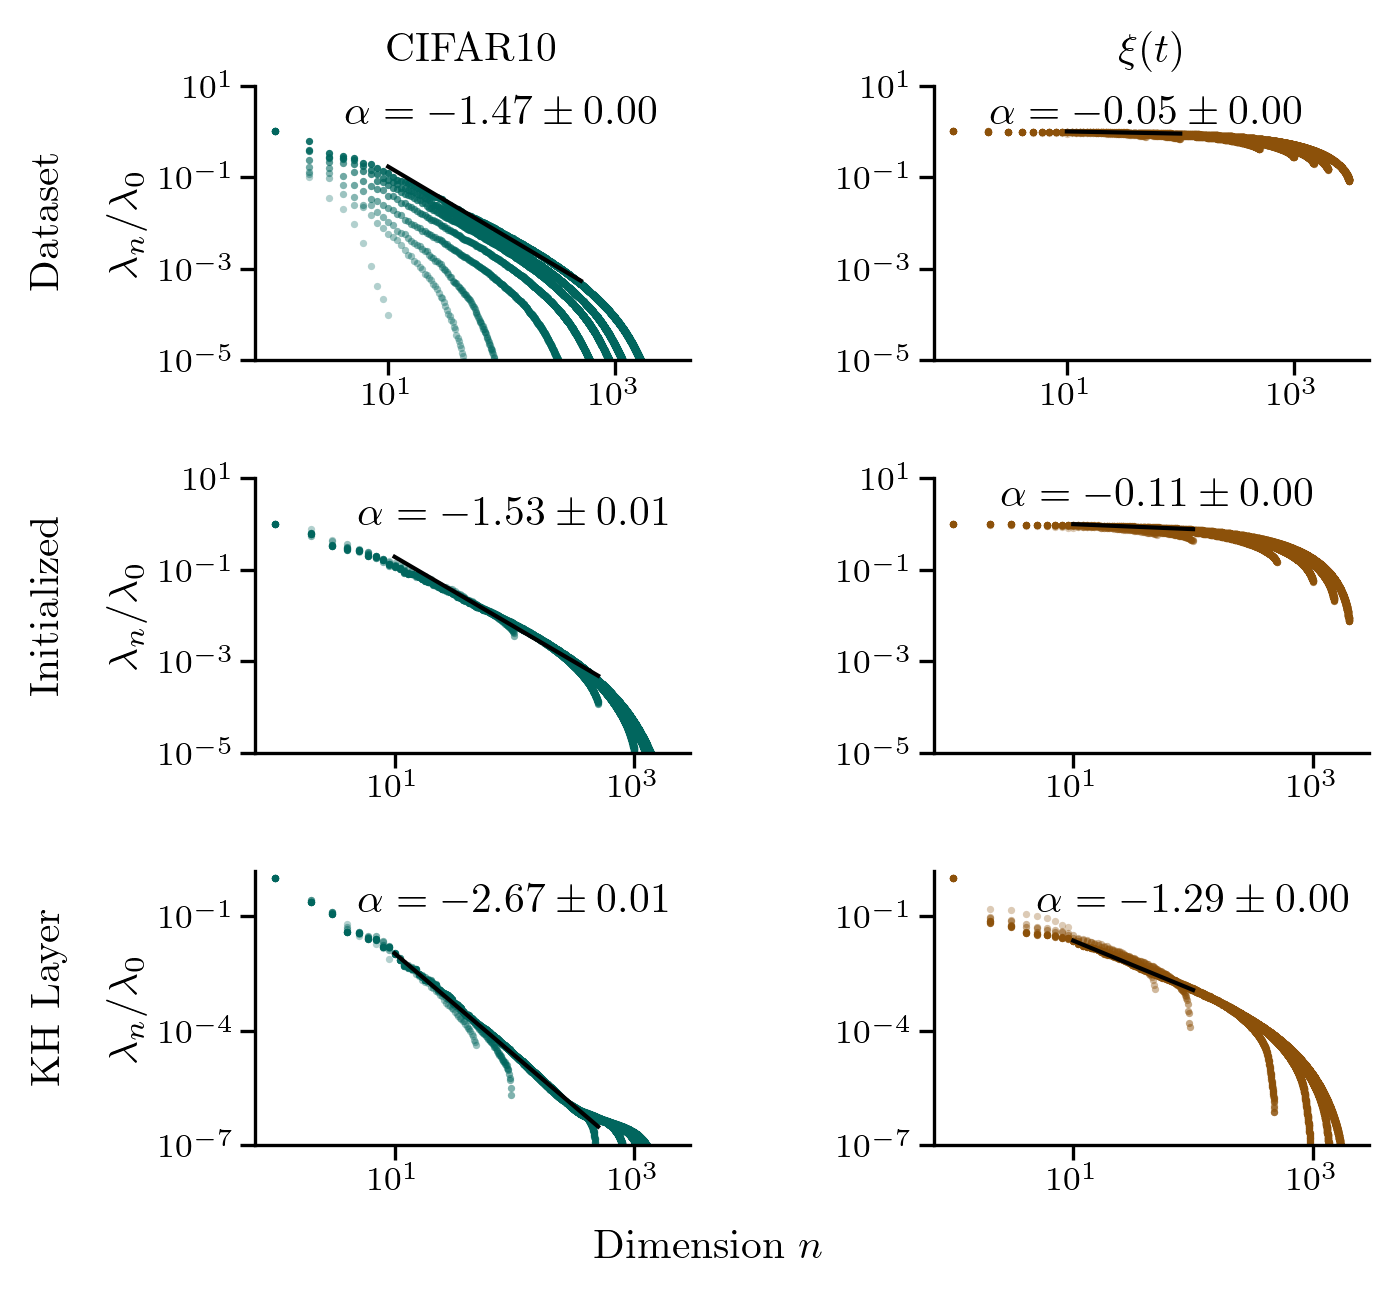

In [81]:
fig = plt.figure(constrained_layout=True)
fig.set_figheight(5.0)
width_ratios = [0.1, 0.5, 0.1, 0.5]
height_ratios = [0.1, 1.0, 0.1, 1.0, 0.1, 1.0]
gs = mpl.gridspec.GridSpec(6, 4, width_ratios=width_ratios, height_ratios=height_ratios)

cifar_ax = fig.add_subplot(gs[1, 1])
gauss_ax = fig.add_subplot(gs[1, 3])
cifar_ax, gauss_ax = plotSpectrum(
    (cifar_ax, gauss_ax),
    SpecE, 
    'LpUnitCIFAR10', 
    'Data', [], 'CIFAR10',
    ylim=(1e-5, 1e+1),
    pos_text_data=(100., 3e0),
    pos_text_gauss=(50., 3e0),
)
cifar_ax.set_title(r"CIFAR10")
gauss_ax.set_title(r"$\xi(t)$")

khmodel_init_cifar_ax = fig.add_subplot(gs[3, 1])
khmodel_init_gauss_ax = fig.add_subplot(gs[3, 3])
khmodel_init_cifar_ax, khmodel_init_gauss_ax = plotSpectrum(
    (khmodel_init_cifar_ax, khmodel_init_gauss_ax),
    SpecE, 
    'shlp_init.pty', 
    'Init', [], 'CIFAR10',
    ylim=(1e-5, 1e+1),
    pos_text_data=(100., 2e0),
    pos_text_gauss=(50., 5e0),
)

khmodel_cifar_ax = fig.add_subplot(gs[5, 1])
khmodel_gauss_ax = fig.add_subplot(gs[5, 3])
khmodel_cifar_ax, khmodel_gauss_ax = plotSpectrum(
    (khmodel_cifar_ax, khmodel_gauss_ax),
    SpecE, 
    'khmodel_cifar10_pruned_thr.pty', 
    'HybridModel', [], 'CIFAR10',
    ylim = (1e-7, 1.5), 
    pos_text_data = (100., 3e-1),
    pos_text_gauss = (100., 3e-1),
)

fig.text(0.1, 0.70, r"Dataset", rotation='vertical', ha='center')
fig.text(0.1, 0.43, r"Initialized", rotation='vertical', ha='center')
fig.text(0.1, 0.17, r"KH Layer", rotation='vertical', ha='center')

fig.text(0.5, 0.05, r"Dimension $n$", ha='center')

fig.savefig(figure_directory / Path("KHModelSpectra.pdf"))
fig.savefig(Path("KHModelSpectra.pdf"))

/tmp/ipykernel_3130414/1293382954.py:78: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(figure_directory / Path("ModelSpectra.pdf"))
/tmp/ipykernel_3130414/1293382954.py:79: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(Path("ModelSpectra.pdf"))
/home/konstantin/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


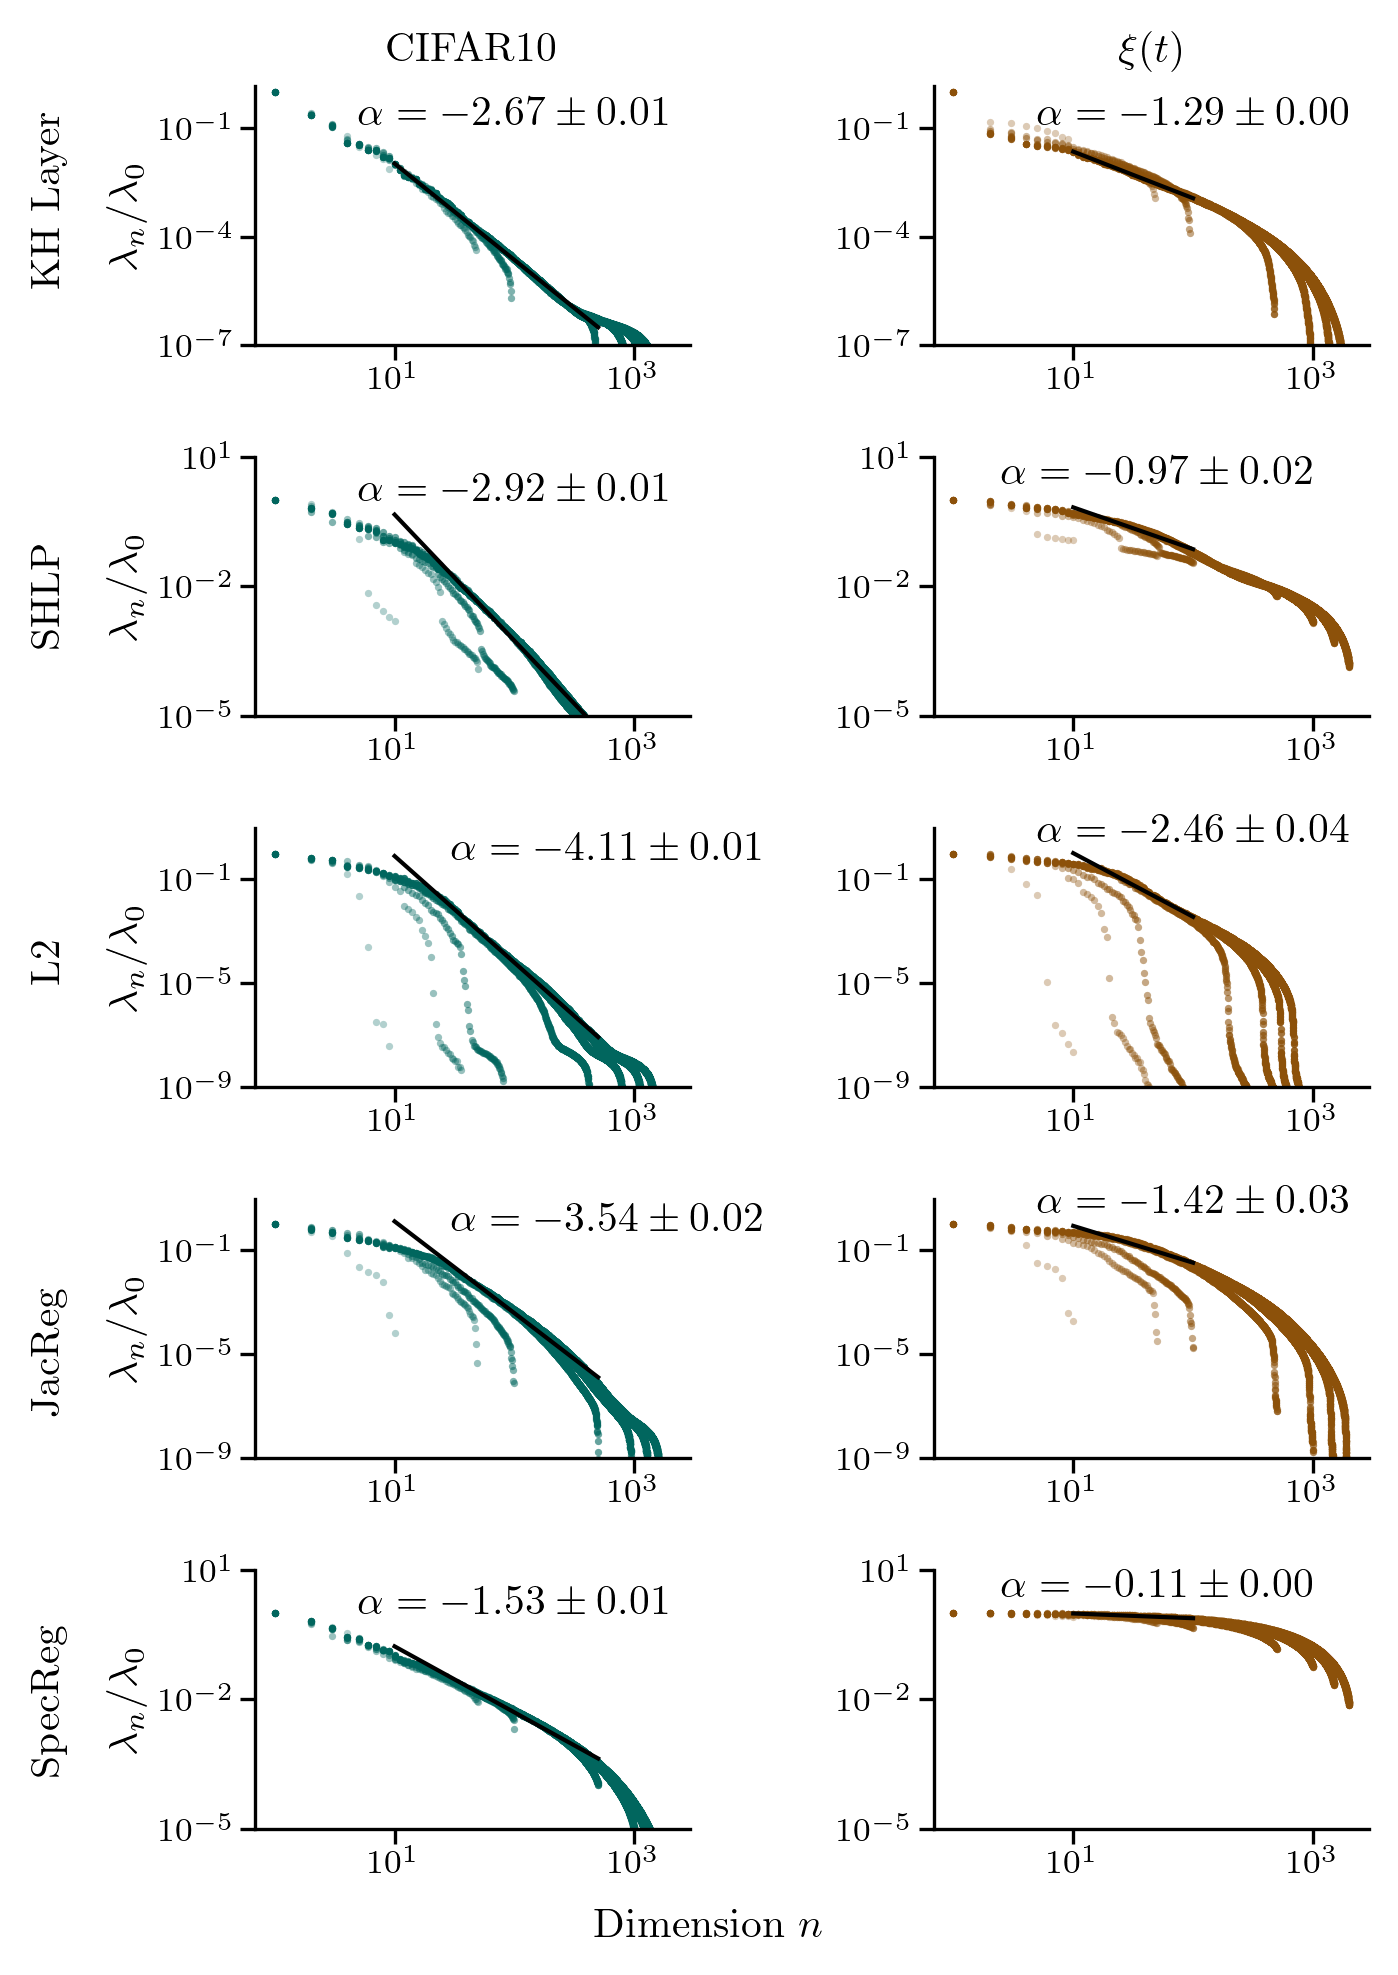

In [102]:
fig = plt.figure(constrained_layout=True)
fig.set_figheight(8.0)
width_ratios = [0.1, 0.5, 0.1, 0.5]
height_ratios = [0.1, 1.0, 0.1, 1.0, 0.1, 1.0, 0.1, 1.0, 0.1, 1.0]
gs = mpl.gridspec.GridSpec(10, 4, width_ratios=width_ratios, height_ratios=height_ratios)


khmodel_cifar_ax = fig.add_subplot(gs[1, 1])
khmodel_gauss_ax = fig.add_subplot(gs[1, 3])
khmodel_cifar_ax, khmodel_gauss_ax = plotSpectrum(
    (khmodel_cifar_ax, khmodel_gauss_ax),
    SpecE, 
    'khmodel_cifar10_pruned_thr.pty', 
    'HybridModel', [], 'CIFAR10',
    ylim = (1e-7, 1.5), 
    pos_text_data = (100., 3e-1),
    pos_text_gauss = (100., 3e-1),
)
khmodel_cifar_ax.set_title(r"CIFAR10")
khmodel_gauss_ax.set_title(r"$\xi(t)$")

shlp_cifar_ax = fig.add_subplot(gs[3, 1])
shlp_gauss_ax = fig.add_subplot(gs[3, 3])
shlp_cifar_ax, shlp_gauss_ax = plotSpectrum(
    (shlp_cifar_ax, shlp_gauss_ax),
    SpecE, 
    'shlp_cifar10.pty', 
    'SHLP', [], 'CIFAR10',
    ylim=(1e-5, 1e+1),
    pos_text_data=(100., 2e0),
    pos_text_gauss=(50., 5e0),
)

shlp_l2_cifar_ax = fig.add_subplot(gs[5, 1])
shlp_l2_gauss_ax = fig.add_subplot(gs[5, 3])
shlp_l2_cifar_ax, shlp_l2_gauss_ax = plotSpectrum(
    (shlp_l2_cifar_ax, shlp_l2_gauss_ax),
    SpecE, 
    'shlp_l2.pty', 
    'L2', [], 'CIFAR10', 
    ylim=(1e-9, 1e+1),
    pos_text_data=(6e2, 2e0),
    pos_text_gauss=(100., 1e1),
)

shlp_jreg_cifar_ax = fig.add_subplot(gs[7, 1])
shlp_jreg_gauss_ax = fig.add_subplot(gs[7, 3])
shlp_jreg_cifar_ax, shlp_jreg_gauss_ax = plotSpectrum(
    (shlp_jreg_cifar_ax, shlp_jreg_gauss_ax),
    SpecE, 
    'shlp_jreg.pty', 
    'JReg', [], 'CIFAR10', 
    ylim=(1e-9, 1e+1),
    pos_text_data=(6e2, 2e0),
    pos_text_gauss=(100., 1e1),
)

shlp_specreg_cifar_ax = fig.add_subplot(gs[9, 1])
shlp_specreg_gauss_ax = fig.add_subplot(gs[9, 3])
shlp_specreg_cifar_ax, shlp_specreg_gauss_ax = plotSpectrum(
    (shlp_specreg_cifar_ax, shlp_specreg_gauss_ax),
    SpecE, 
    'shlp_specreg.pty', 
    'SpecReg', [], 'CIFAR10', 
    ylim=(1e-5, 1e+1),
    pos_text_data=(100., 2e0),
    pos_text_gauss=(50., 5e0),
)

fig.text(0.1, 0.77, r"KH Layer", rotation='vertical', ha='center')
fig.text(0.1, 0.62, r"SHLP", rotation='vertical', ha='center')
fig.text(0.1, 0.48, r"L2", rotation='vertical', ha='center')
fig.text(0.1, 0.3, r"JacReg", rotation='vertical', ha='center')
fig.text(0.1, 0.15, r"SpecReg", rotation='vertical', ha='center')

fig.text(0.5, 0.08, r"Dimension $n$", ha='center')

fig.savefig(figure_directory / Path("ModelSpectra.pdf"))
fig.savefig(Path("ModelSpectra.pdf"))